# Store item forcast - arima

In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import gc
import statsmodels.api as sm
plt.style.use('ggplot')
%matplotlib inline

## Load dataset

In [152]:
path ='dataset/'
#path ='../input/'
train = pd.read_csv(path + 'train.csv',parse_dates=[0] )
test = pd.read_csv(path+ 'test.csv',parse_dates=[1] )
print('Number of rows and columns in train dataset are:',train.shape)
print('Number of rows and columns in train dataset are:', test.shape)

Number of rows and columns in train dataset are: (913000, 4)
Number of rows and columns in train dataset are: (45000, 4)


## Exploratory data analysis

In [102]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


The test dataset contains id column but train dataset does not contains id column. While importing dataset parse_date is assigned with perticular column index.

In [4]:
def basic_details(df):
    """Find number of missing value,dtyeps, unique value in 
    dataset"""
    k = pd.DataFrame()
    k['Missing value'] = df.isnull().sum()
    k['% Missing value'] = df.isnull().sum()/df.shape[0]
    k['dtype'] = df.dtypes
    k['N unique'] = df.nunique()
    return k

basic_details(train) # train dataset

,Missing value,% Missing value,dtype,N unique
date,0,0.0,datetime64[ns],1826
store,0,0.0,int64,10
item,0,0.0,int64,50
sales,0,0.0,int64,213


In [5]:
basic_details(test) # test dataset

,Missing value,% Missing value,dtype,N unique
id,0,0.0,int64,45000
date,0,0.0,datetime64[ns],90
store,0,0.0,int64,10
item,0,0.0,int64,50


In [6]:
train.describe() # descriptive statistics about features

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


There are 50 diffirent item in 10 diffirent stores. The maximum number of items sold is 231 and average item sold is 52.25.

## Date
Let's extract day, week, month, year from date feature

In [23]:
print('Time series start time: "{}" and end time: "{}"'.format(train['date'].min(), train['date'].max()))
print('Time series start time: "{}" and end time: "{}"'.format(test['date'].min(), test['date'].max()))

Time series start time: "2013-01-01 00:00:00" and end time: "2017-12-31 00:00:00"
Time series start time: "2018-01-01 00:00:00" and end time: "2018-03-31 00:00:00"


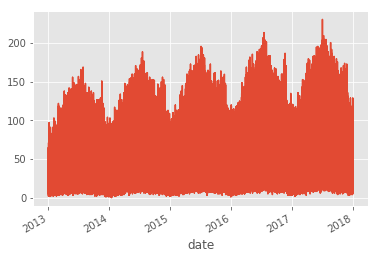

In [33]:
train.set_index('date')['sales'].plot(kind='line')

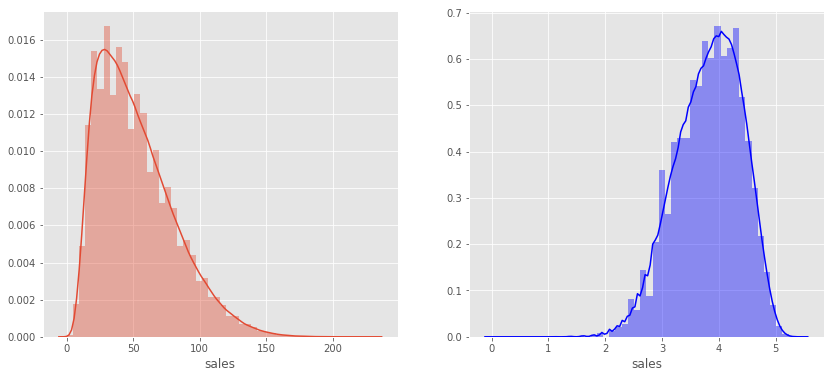

In [115]:
f,ax = plt.subplots(1,2,figsize=(14,6))
sns.distplot(train['sales'],ax =ax[0])
sns.distplot(np.log(train['sales']+1),ax=ax[1], color='b')

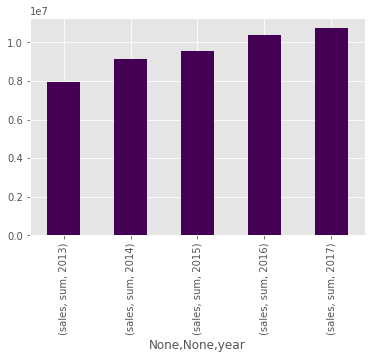

In [31]:
(train
 .groupby(['year',])
 .agg({'sales':['sum']})
 .unstack()
 .plot(kind='bar',cmap='viridis'))

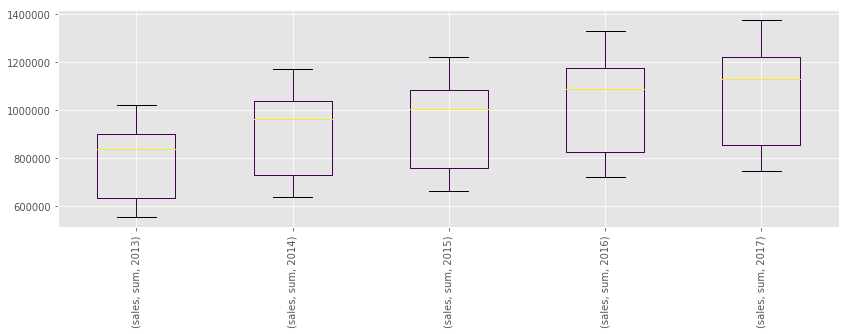

In [32]:
(train
 .groupby(['store','year'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,4),kind='box',stacked=True,cmap='viridis'))
plt.xticks(rotation=90);

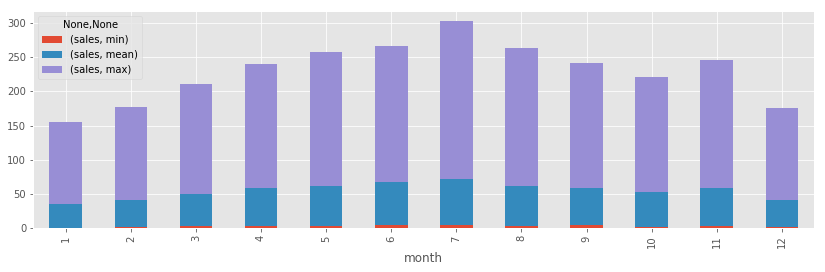

In [113]:
train.groupby('month').agg({'sales':['min','mean','max']}).plot(figsize=(14,4),kind='bar',stacked=True)

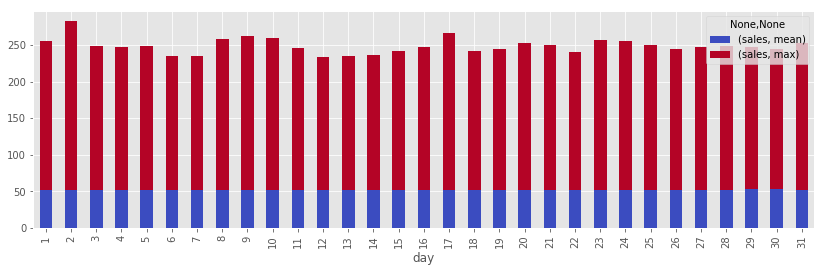

In [114]:
train.groupby(['day']).agg({'sales':['mean','max']}).plot(figsize=(14,4),kind='bar',stacked=True,cmap='coolwarm')

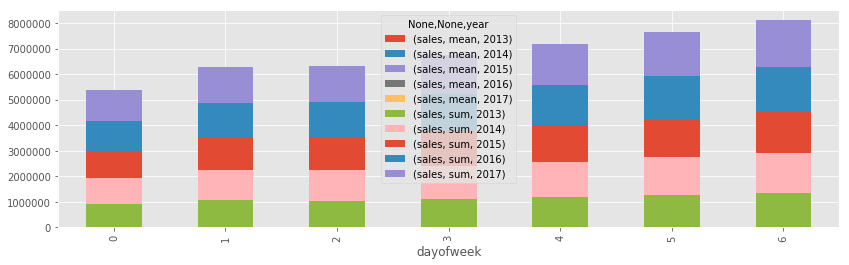

In [115]:
train.groupby(['dayofweek','year']).agg({'sales':['mean','sum']}).unstack().plot(figsize=(14,4),kind='bar',stacked=True)

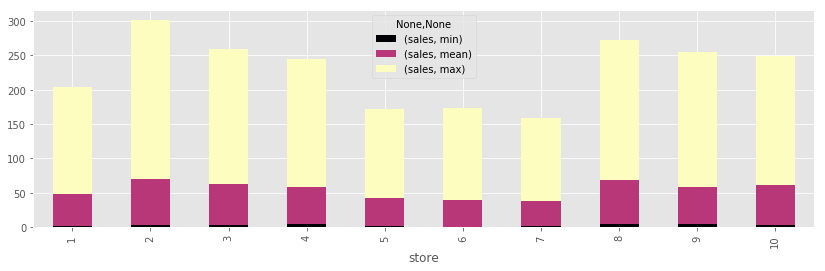

In [116]:
(train
 .groupby('store')
 .agg({'sales':['min','mean','max']})
 .plot(figsize=(14,4),kind='bar',stacked=True,cmap='magma'))

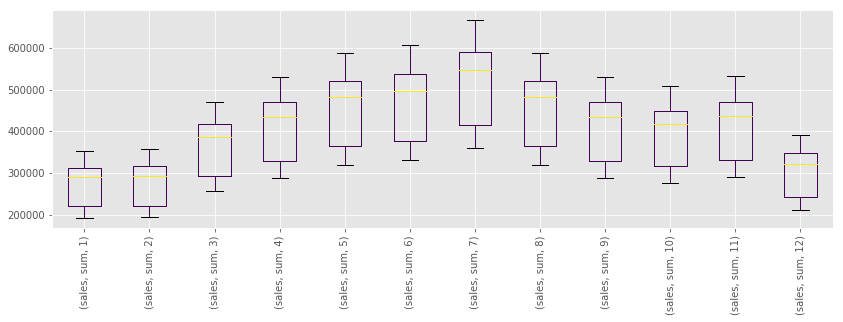

In [117]:
(train
 .groupby(['store','month'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,4),kind='box',stacked=True,cmap='viridis'))
plt.xticks(rotation=90);

## item

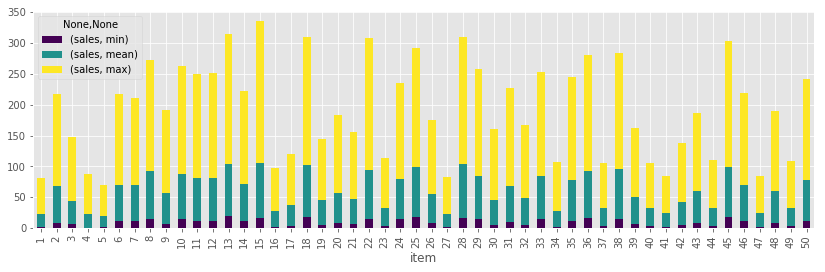

In [118]:
(train
 .groupby('item')
 .agg({'sales':['min','mean','max']})
 .plot(figsize=(14,4),kind='bar',stacked=True,cmap='viridis'))

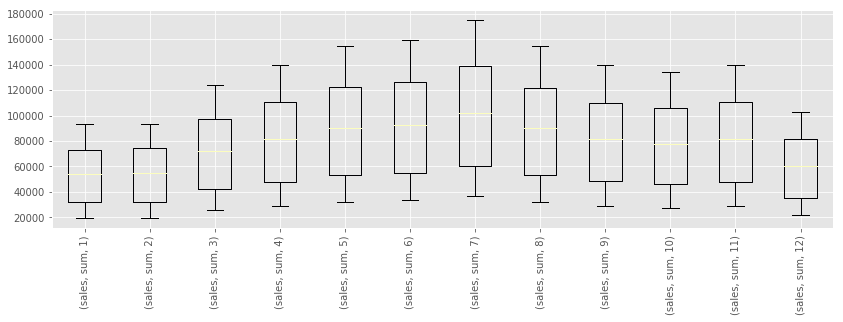

In [119]:
(train
 .groupby(['item','month'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,4),kind='box',stacked=True,cmap='magma'))
plt.xticks(rotation=90);

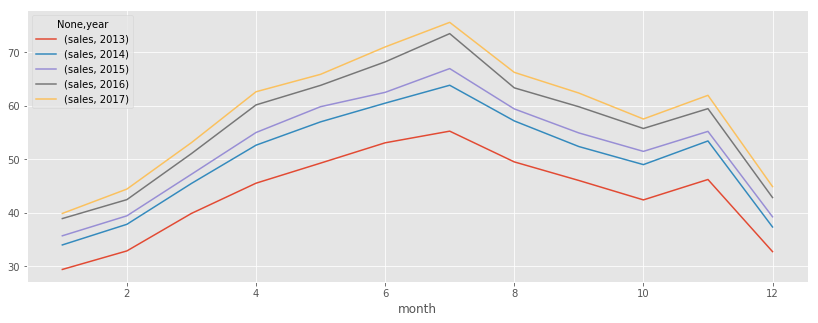

In [120]:
(train
 .groupby(['month','year'])
 .agg({'sales':'mean'})
 .unstack()
 .plot(figsize=(14,5)))

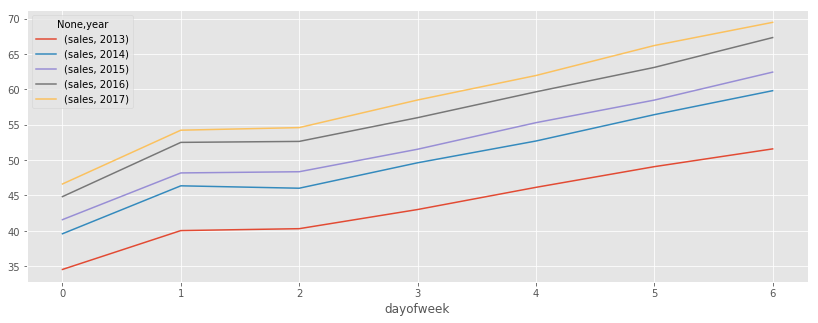

In [121]:
(train
 .groupby(['dayofweek','year'])
 .agg({'sales':'mean'})
 .unstack()
 .plot(figsize=(14,5)))

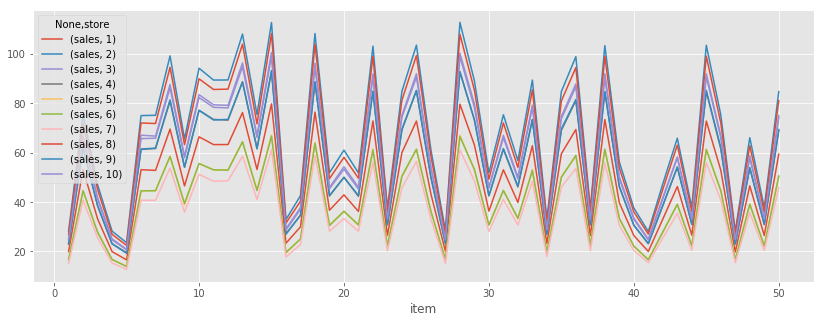

In [101]:
(train
 .groupby(['item','store'])
 .agg({'sales':'mean'})
 .unstack()
 .plot(figsize=(14,5),kind='line'))

In [123]:
train1 =train
train1['month'] = train1['date'].dt.month_name()

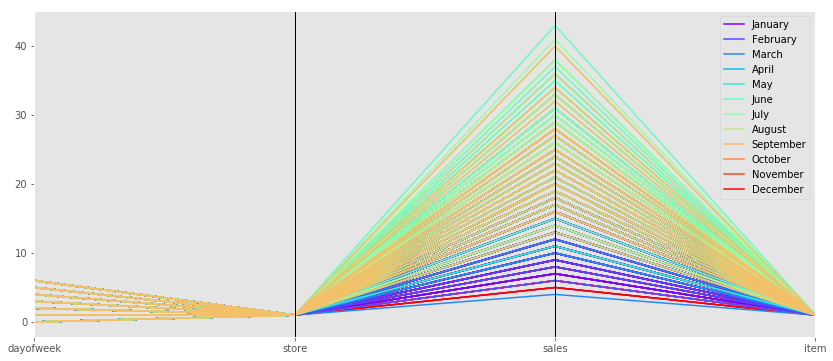

In [132]:
plt.figure(figsize=(14,6))
pd.plotting.parallel_coordinates(train1[['dayofweek','store','sales','item','month']][:1000],'month',colormap='rainbow')

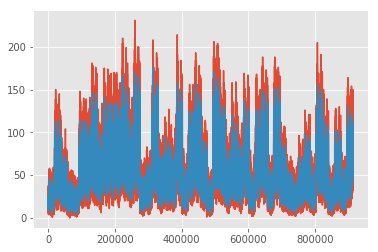

In [67]:
train['sales'].plot()
train['sales'].rolling(window=7).mean().dropna().plot()

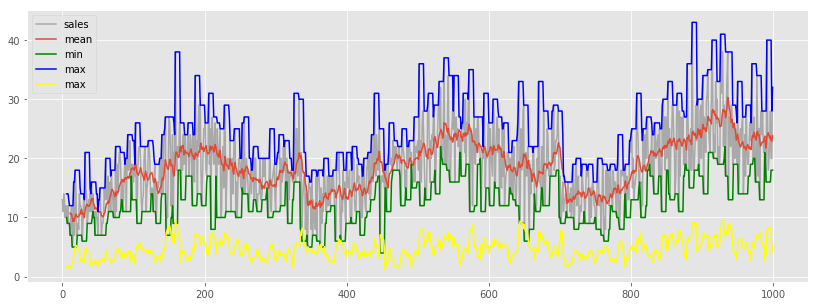

In [44]:
plt.figure(figsize=(14,5))
train['sales'].head(1000).plot(color='darkgray')
train['sales'].head(1000).rolling(window=12).mean().plot(label='mean')
#train['sales'].head(1000).rolling(window=12).median().plot(label='median')
train['sales'].head(1000).rolling(window=7).min().plot(label='min',color='g')
train['sales'].head(1000).rolling(window=7).max().plot(label='max',color='b')
train['sales'].head(1000).rolling(window=7).std().plot(label='max',color='yellow')
plt.legend()

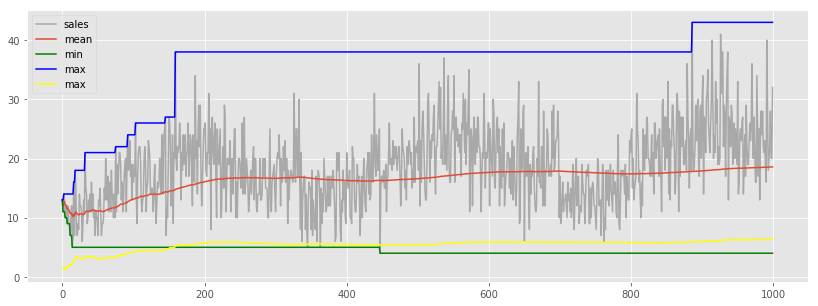

In [101]:
# Expanding window
plt.figure(figsize=(14,5))
train['sales'].head(1000).plot(color='darkgray')
train['sales'].head(1000).expanding().mean().plot(label='mean')
#train['sales'].head(1000).rolling(window=12).median().plot(label='median')
train['sales'].head(1000).expanding().min().plot(label='min',color='g')
train['sales'].head(1000).expanding().max().plot(label='max',color='b')
train['sales'].head(1000).expanding().std().plot(label='max',color='yellow')
plt.legend()

## Combine train and test dataset

In [164]:
train['id'] = np.nan
train['is_train'] = True
test['is_train'] = False
test['sales'] = np.nan

# concat train,test
train_test = pd.concat([train,test],axis=0)

#Log transform
train_test['sales_log'] = np.log(train_test['sales']+1)
gc.collect()
train_test.shape

/home/sudhir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


(958000, 7)

In [165]:
#train_test['date'] = pd.to_datetime(train_test['date'].values)
train_test['day'] = train_test['date'].dt.day
train_test['dayofweek'] = train_test['date'].dt.dayofweek
train_test['month'] = train_test['date'].dt.month
train_test['year'] = train_test['date'].dt.year
train_test['weekofyear'] = train_test['date'].dt.weekofyear
train_test['is_month_start'] = train_test['date'].dt.is_month_start.astype('int8')
train_test['is_month_end'] = train_test['date'].dt.is_month_end.astype('int8')

gc.collect()
train_test.head()

,date,id,is_train,item,sales,store,sales_log,day,dayofweek,month,year,weekofyear,is_month_start,is_month_end
0,2013-01-01,NaN,True,1,13.0,1,2.639057,1,1,1,2013,1,1,0
1,2013-01-02,NaN,True,1,11.0,1,2.484907,2,2,1,2013,1,0,0
2,2013-01-03,NaN,True,1,14.0,1,2.708050,3,3,1,2013,1,0,0
3,2013-01-04,NaN,True,1,13.0,1,2.639057,4,4,1,2013,1,0,0
4,2013-01-05,NaN,True,1,10.0,1,2.397895,5,5,1,2013,1,0,0


### Aggregate

In [166]:
def aggregate_groupby(df,columns):
    agg = df.groupby(columns).agg({'sales':['min','max','sum','mean','median','std']})
    agg.columns = pd.Index(['_&_'.join(columns)+ '_'+'_&_'.join(e) for e in agg.columns.tolist()])
    df = pd.merge(df, agg, how= 'left',on= columns)
    return df

In [151]:
"""train_test = aggregate_groupby(train_test,columns=['store','day',])
train_test = aggregate_groupby(train_test,columns=['store','month',])
train_test = aggregate_groupby(train_test,columns=['store','dayofweek',])

train_test = aggregate_groupby(train_test,columns=['item','day',])
train_test = aggregate_groupby(train_test,columns=['item','month',])
train_test = aggregate_groupby(train_test,columns=['item','dayofweek',])
train_test.shape"""

"train_test = aggregate_groupby(train_test,columns=['store','day',])\ntrain_test = aggregate_groupby(train_test,columns=['store','month',])\ntrain_test = aggregate_groupby(train_test,columns=['store','dayofweek',])\n\ntrain_test = aggregate_groupby(train_test,columns=['item','day',])\ntrain_test = aggregate_groupby(train_test,columns=['item','month',])\ntrain_test = aggregate_groupby(train_test,columns=['item','dayofweek',])\ntrain_test.shape"

### Rolling and ewm aggregate

In [167]:
def extract_precedent_statistics(df, on, group_by):
    
    df.sort_values(group_by + ['date'], inplace=True)
    
    groups = df.groupby(group_by, sort=False)
    
    stats = {
        'mean': [],
        'median': [],
        'std': [],
        'count': [],
        'max': [],
        'min': []
    }
    
    exp_alphas = [0.1, 0.25, 0.3, 0.5, 0.75]
    stats.update({'exp_{}_mean'.format(alpha): [] for alpha in exp_alphas})
    
    for _, group in groups:
        
        shift = group[on].shift()
        roll = shift.rolling(window=len(group), min_periods=1)
        
        stats['mean'].extend(roll.mean())
        stats['median'].extend(roll.median())
        stats['std'].extend(roll.std())
        stats['count'].extend(roll.count())
        stats['max'].extend(roll.max())
        stats['min'].extend(roll.min())
        
        for alpha in exp_alphas:
            exp = shift.ewm(alpha=alpha, adjust=False)
            stats['exp_{}_mean'.format(alpha)].extend(exp.mean())
    
    suffix = '_&_'.join(group_by)
    
    for stat_name, values in stats.items():
        df['{}_{}_by_{}'.format(on, stat_name, suffix)] = values


In [168]:
extract_precedent_statistics( df=train_test,on='sales',group_by=['store', 'day'])
extract_precedent_statistics( df=train_test,on='sales',group_by=['store', 'dayofweek'])
extract_precedent_statistics( df=train_test,on='sales',group_by=['item', 'day'])
extract_precedent_statistics( df=train_test,on='sales',group_by=['item', 'dayofweek'])
extract_precedent_statistics( df=train_test,on='sales',group_by=['store', 'item'])


In [170]:
extract_precedent_statistics( df=train_test,on='sales_log',group_by=['store', 'day'])
extract_precedent_statistics( df=train_test,on='sales_log',group_by=['store', 'dayofweek'])
extract_precedent_statistics( df=train_test,on='sales_log',group_by=['item', 'day'])
extract_precedent_statistics( df=train_test,on='sales_log',group_by=['item', 'dayofweek'])
extract_precedent_statistics( df=train_test,on='sales_log',group_by=['store', 'item'])


In [172]:
train_test.shape

(958000, 124)

### One hot encoding

In [174]:
def one_hot_encoding(df,columns):
    print('Original shape',df.shape)
    df = pd.get_dummies(df,drop_first=True,columns=columns)
    print('After OHE', df.shape)
    return df

In [175]:
train_test1 = one_hot_encoding(train_test,columns=['month','dayofweek'])

Original shape (958000, 124)
After OHE (958000, 139)


In [173]:
#plt.figure(figsize=(14,10))
#sns.heatmap(train_test1.corr(), cmap='coolwarm', annot=True,fmt='.2f')

## Time Series

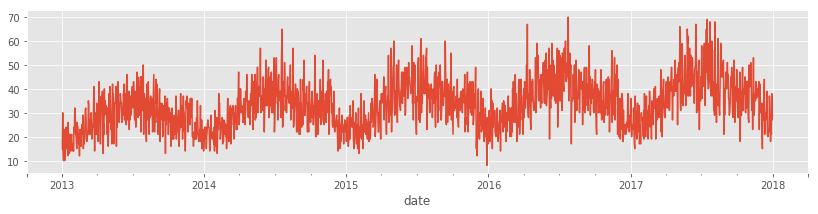

In [6]:
train[(train['store']==1) & (train['item']==3)].set_index('date')['sales'].plot(figsize=(14,3))

In [11]:
def ts_plot(y, lags=None, title =''):
    """ Time series plot,histogram, acf,pacf plot"""
    f, ax = plt.subplots(2,2,figsize=(14,8))
    y.plot(title=title,color='blue',ax=ax[0,0])
    #ax[0].set_title(title)
    y.plot(kind='hist', ax=ax[0,1],bins=25)
    sm.tsa.graphics.plot_acf(y, ax=ax[1,0], lags=lags)
    sm.tsa.graphics.plot_pacf(y, ax=ax[1,1], lags=lags)
    plt.tight_layout()

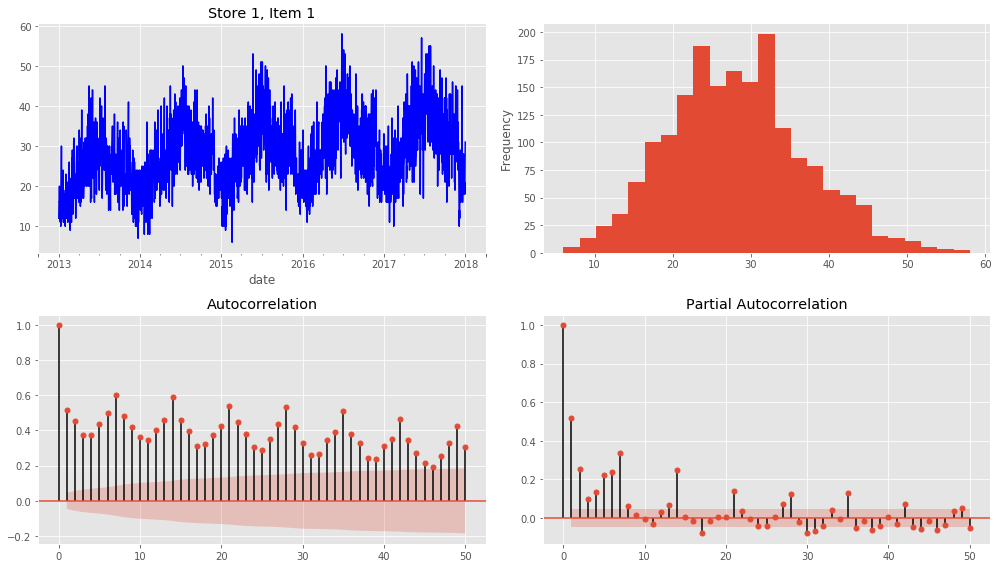

In [18]:
ts = train[(train['store']==2) & (train['item']==1)].set_index('date')['sales']
ts_plot(ts,lags=50,title='Store 1, Item 1')

In [ ]:
adf_test = sm.tsa.adfuller(ts.dropna())
output =pd.Series(adf_test[:4],index =['test_stat','p-value','uselag','nobs'])

for name,value in adf_test[4].items():
    output['critival value {}',name] = value
output

In [19]:
test_adf = sm.tsa.adfuller(ts.diff().dropna())
arr = [i for i in test_adf]
test_adf1 =pd.DataFrame()
test_adf1['values'] =arr
test_adf1.index = ['test_stat','p-value','uselag','nobs','critical value','icbf']
test_adf1

,values
test_stat,-12.6768
p-value,1.21093e-23
uselag,22
nobs,1802
critical value,"{'1%': -3.43398409526, '5%': -2.8631452508, '1..."
icbf,10899.5


Time series is stationary

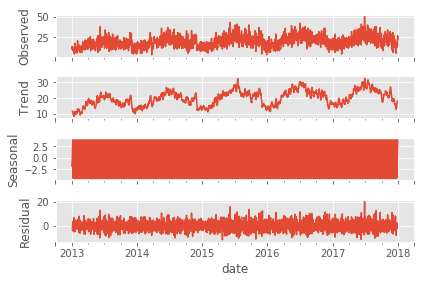

In [20]:
# seasonal decompose
res = sm.tsa.seasonal_decompose(ts)
ax = res.plot()


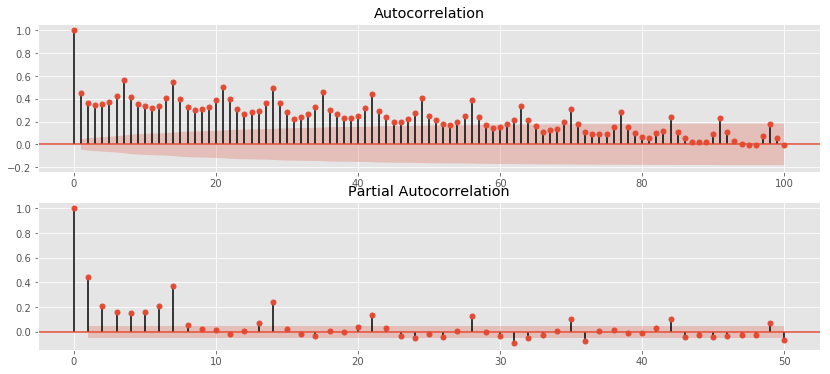

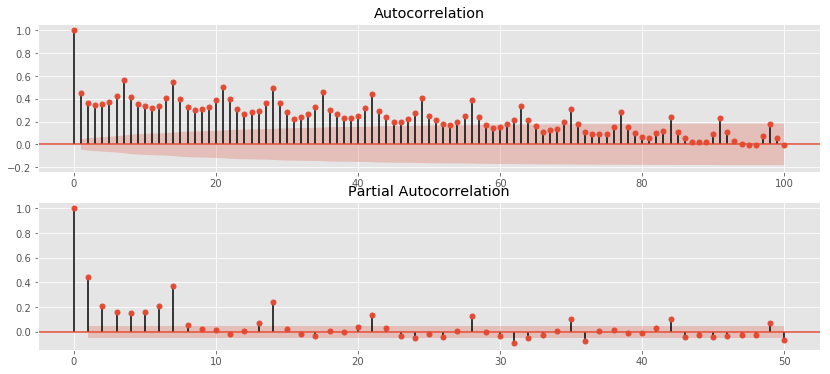

In [166]:
f =plt.figure(figsize=(14,6))
ax1 = plt.subplot(211)
sm.tsa.graphics.plot_acf(ts, ax=ax1,lags= 100)
ax2 = plt.subplot(212)
sm.tsa.graphics.plot_pacf(ts,ax=ax2,lags=50)

> ARIMA(7,0,0)

In [205]:
# Data prepare
ts_train = train1[(train1['store']==1) & (train1['item']==1)].set_index('date')
endog = ts_train['sales']
ts_train = ts_train.drop(['sales','item','store'], axis=1)

# Split into train test dataset
tr_start,tr_end =pd.Timestamp('2013-01-01'),pd.Timestamp('2016-12-31') # 2013, 2014,2015
te_start,te_end =pd.Timestamp('2017-01-01'),pd.Timestamp('2017-12-31') # 2016, 2017

X_train, X_test = ts_train[tr_start:tr_end],ts_train[te_start:te_end]
y_train, y_test = endog[tr_start:tr_end],endog[te_start:te_end]

In [183]:
# ARIMA
model = sm.tsa.ARIMA(endog=y_train,order=(7,0,0),exog=X_train).fit()
model.summary()

/home/sudhir/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1461
Model:                     ARMA(7, 0)   Log Likelihood               -4208.529
Method:                       css-mle   S.D. of innovations              4.313
Date:                Mon, 03 Sep 2018   AIC                           8479.057
Time:                        13:59:50   BIC                           8642.950
Sample:                    01-01-2013   HQIC                          8540.194
                         - 12-31-2016                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -3479.5763    147.547    -23.583      0.000   -3768.763   -3190.389
day                 0.0112      0.015      0.758      0.448      -0.018       0.040
year                1.7353      0.073     23.692      0.000       1.592       1.879
weekofyear         -0.0155      0.031     -0.509      0.611      -0.075       0.044
is_month_start      0.2798      0.667      0.420      0.675      -1.027       1.587
is_month_end        0.6312      0.669      0.944      0.345      -0.679       1.942
month_August        1.5841      0.793      1.997      0.046       0.029       3.139
month_December     -5.6830      1.158     -4.906      0.000      -7.953      -3.413
month_February     -6.5569      0.654    -10.033      0.000      -7.838      -5.276
month_January      -7.4173      0.682    -10.872      0.000      -8.755      -6.080
month_July          5.2165      0.712      7.324      0.000       3.821       6.612
month_June          3.7253      0.650      5.736      0.000       2.452       4.998
month_March        -3.0465      0.598     -5.098      0.000      -4.218      -1.875
month_May           1.1658      0.597      1.952      0.051      -0.005       2.336
month_November      1.1811      1.104      1.070      0.285      -0.982       3.344
month_October      -0.7752      0.993     -0.780      0.435      -2.722       1.172
month_September     0.6344      0.893      0.711      0.477      -1.115       2.384
dayofweek_1         2.6112      0.431      6.060      0.000       1.767       3.456
dayofweek_2         3.1020      0.440      7.046      0.000       2.239       3.965
dayofweek_3         3.5691      0.440      8.107      0.000       2.706       4.432
dayofweek_4         5.4264      0.440     12.326      0.000       4.564       6.289
dayofweek_5         6.9879      0.440     15.873      0.000       6.125       7.851
dayofweek_6         7.9248      0.431     18.371      0.000       7.079       8.770
ar.L1.sales         0.0177      0.026      0.676      0.499      -0.034       0.069
ar.L2.sales        -0.0185      0.026     -0.705      0.481      -0.070       0.033
ar.L3.sales        -0.0058      0.026     -0.221      0.825      -0.057       0.046
ar.L4.sales         0.0045      0.026      0.172      0.864      -0.047       0.056
ar.L5.sales         0.0161      0.026      0.610      0.542      -0.036       0.068
ar.L6.sales         0.0220      0.026      0.836      0.404      -0.030       0.074
ar.L7.sales         0.0389      0.026      1.483      0.138      -0.013       0.090
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4942           -0.0000j            1.4942           -0.0000
AR.2            0.8820           -1.2557j            1.5345           -0.1525
A

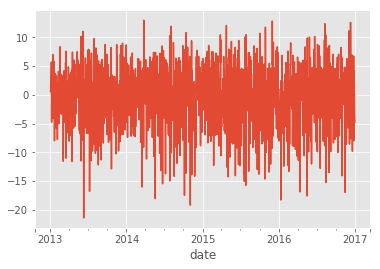

In [159]:
model.fittedvalues.plot()

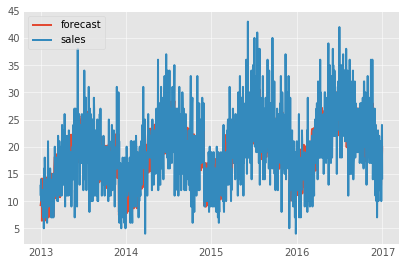

<Figure size 1008x216 with 0 Axes>

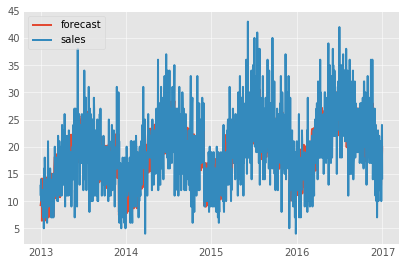

In [193]:
plt.figure(figsize=(14,3))
model.plot_predict(plot_insample=True)

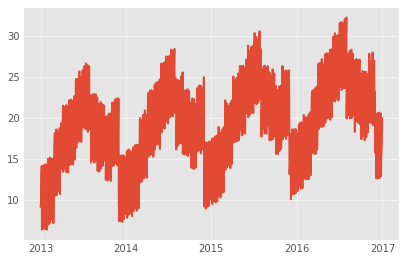

In [197]:
model.predict().plot()

In [211]:
X_test.shape

(365, 17)

In [214]:
model.predict(start=1462,end=1462+365,exog=X_test)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [215]:
import numpy as np
import pylab as pl
from numpy import fft
    
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 10                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = range(n)
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t
    
def main():
    x = np.array([669, 592, 664, 1005, 699, 401, 646, 472, 598, 681, 1126, 1260, 562, 491, 714, 530, 521, 687, 776, 802, 499, 536, 871, 801, 965, 768, 381, 497, 458, 699, 549, 427, 358, 219, 635, 756, 775, 969, 598, 630, 649, 722, 835, 812, 724, 966, 778, 584, 697, 737, 777, 1059, 1218, 848, 713, 884, 879, 1056, 1273, 1848, 780, 1206, 1404, 1444, 1412, 1493, 1576, 1178, 836, 1087, 1101, 1082, 775, 698, 620, 651, 731, 906, 958, 1039, 1105, 620, 576, 707, 888, 1052, 1072, 1357, 768, 986, 816, 889, 973, 983, 1351, 1266, 1053, 1879, 2085, 2419, 1880, 2045, 2212, 1491, 1378, 1524, 1231, 1577, 2459, 1848, 1506, 1589, 1386, 1111, 1180, 1075, 1595, 1309, 2092, 1846, 2321, 2036, 3587, 1637, 1416, 1432, 1110, 1135, 1233, 1439, 894, 628, 967, 1176, 1069, 1193, 1771, 1199, 888, 1155, 1254, 1403, 1502, 1692, 1187, 1110, 1382, 1808, 2039, 1810, 1819, 1408, 803, 1568, 1227, 1270, 1268, 1535, 873, 1006, 1328, 1733, 1352, 1906, 2029, 1734, 1314, 1810, 1540, 1958, 1420, 1530, 1126, 721, 771, 874, 997, 1186, 1415, 973, 1146, 1147, 1079, 3854, 3407, 2257, 1200, 734, 1051, 1030, 1370, 2422, 1531, 1062, 530, 1030, 1061, 1249, 2080, 2251, 1190, 756, 1161, 1053, 1063, 932, 1604, 1130, 744, 930, 948, 1107, 1161, 1194, 1366, 1155, 785, 602, 903, 1142, 1410, 1256, 742, 985, 1037, 1067, 1196, 1412, 1127, 779, 911, 989, 946, 888, 1349, 1124, 761, 994, 1068, 971, 1157, 1558, 1223, 782, 2790, 1835, 1444, 1098, 1399, 1255, 950, 1110, 1345, 1224, 1092, 1446, 1210, 1122, 1259, 1181, 1035, 1325, 1481, 1278, 769, 911, 876, 877, 950, 1383, 980, 705, 888, 877, 638, 1065, 1142, 1090, 1316, 1270, 1048, 1256, 1009, 1175, 1176, 870, 856, 860])
    n_predict = 100
    extrapolation = fourierExtrapolation(x, n_predict)
    pl.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
    pl.plot(np.arange(0, x.size), x, 'b', label = 'x', linewidth = 3)
    pl.legend()
    pl.show()
    
if __name__ == "__main__":
    main()

AttributeError: 'range' object has no attribute 'sort'

In [ ]:
# Model
from sklearn.model_selection import train_test_split
#X = train.drop(['sales','date'], axis=1)
#y = train['sales']
#test_new = test.drop(['date','id'], axis =1)
X_train, X_test, y_train, y_test = train_test_split(train2, y, test_size=0.3, random_state= 234)

In [ ]:
# Linear regression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
lin_reg.score(X_test,y_test)

In [ ]:
# Random forest
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=200, max_depth=5,)
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)
rf_reg.score(X_test,y_test)

In [ ]:
# Model evaluation
from sklearn.metrics import mean_squared_error
print('Root mean_squared_error',np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
sns.distplot(y_pred)

In [ ]:
y_pred_new = lin_reg.predict(test2)
#y_pred_new = rf_reg.predict(test2)
y_pred_new[y_pred_new<0] =0
#y_pred_new = rf_reg.predict(test_new)
submit = pd.DataFrame({'id': test['id'], 'sales':y_pred_new})
submit.to_csv('store_submit.csv',index=False)
submit.head()

# Thank you